In [10]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np  
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten,Input,concatenate,BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split  

(1638, 24, 24, 2)

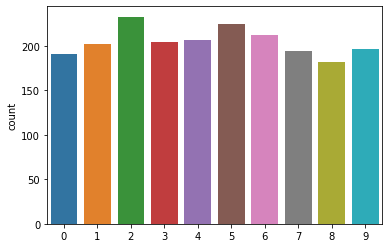

In [16]:

x_train =  np.load("./data/x_train.npy") 
y_train = np.load("./data/y_train.npy" )
x_test = np.load("./data/x_test.npy")  
y_test = np.load("./data/y_test.npy") #y letter
sns.countplot(y_train)
x_train, x_val ,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2,random_state=0,stratify=y_train) 

#알파벳 숫자 값
y_letter = x_train[:,0] 
val_letter = x_val[:,0]

#2차원 필요
scaler = MinMaxScaler()   
x_train = scaler.fit_transform(x_train[:,1:])
x_val = scaler.transform(x_val[:,1:])
x_test = scaler.transform(x_test)

#테두리 잘라주기 
x_train = (x_train.reshape(-1,28,28 )) [:,2:-2,2:-2,np.newaxis]
x_val = (x_val.reshape(-1,28,28 )) [:,2:-2,2:-2,np.newaxis] 
x_test = (x_test.reshape(-1,28,28 )) [:,2:-2,2:-2,np.newaxis]      

#그림
l_train = x_train.copy()
l_val = x_val.copy()
l_test = x_test.copy()
x_train[x_train<0.6]  = 0
x_val[x_val<0.6]  = 0
x_test[x_test<0.6]  = 0

l_train[l_train>0.6] = 0.6
l_val[l_val>0.6] = 0.6
l_test[l_test>0.6] = 0.6  
x_train = np.concatenate((x_train,l_train),axis=3)
x_val = np.concatenate((x_val,l_val),axis=3)
x_test = np.concatenate((x_test,l_test),axis=3)

x_train.shape

In [3]:
i = 0
img = x_train[i] 
img[img<0.6] = 0
plt.imshow(img.reshape(24,24), cmap=plt.get_cmap('Greys')) 
print(y_train[i],chr(65+y_letter[i]))
# show the plot
plt.show()

ValueError: cannot reshape array of size 1152 into shape (24,24)

In [ ]:

#letter x_train[x_train > 0.7] = 0.7
# x_letter[x_letter > 0.7 ] = 0.7   

In [4]:
def DataGen_train():
    from tensorflow.keras.preprocessing.image import ImageDataGenerator 

    train_datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.2,
            height_shift_range=0.2,  
            zoom_range=0.2, 
            shear_range=0.2, 
            featurewise_center=True, 
            featurewise_std_normalization=True
    )   
    model = modeling()
    
    #만든 이미지로 학습 
    train_datagenerator = train_datagen.flow(x_train, y_train,batch_size=20)
 
    model.fit(
            train_datagenerator,
            steps_per_epoch=1000 // 25, 
            epochs=200) 
        # configure batch size and retrieve one batch of images
    return model     
#     for  X_batch , y_batch in train_datagen.flow( x_train , y_train ,batch_size=9):
#         # create a grid of 3x3 images
#         for i in range(0, 9):
#             plt.subplot(330 + 1 + i)
#             plt.imshow(X_batch[i].reshape(26,26), cmap=plt.get_cmap('gray')) 
#             print(y_batch[i],chr(65+l_batch[i]))
#     # show the plot
#         plt.show()
#         break 

In [5]:
def conv(inputs):
    x = Conv2D(50,(2,2),activation='elu',padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64,(3,3),strides=2,activation='elu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.2)(x)
    x = Conv2D(32,(3,3),activation='elu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size= (2,2))(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x
def modeling():
    digit = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])) 
    x = conv(digit) 
    c = Dense(100, activation='elu')(digit)
    c = Dropout(0.2)(c)
    c = Dense(64, activation='elu')(c)
    c = Dropout(0.2)(c)
    c = Dense(32, activation='elu')(c)   
    c = Dense(26, activation='softmax')(c)
    
    x = Dense(100, activation='elu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='elu')(x )
    x = Dropout(0.2)(x)
    x = Dense(32, activation='elu')(x )  
    x = Dropout(0.2)(x)
    x = Dense(50, activation='elu')(x) 
    x = Dropout(0.2)(x)
    x = Dense(20, activation='elu')(x)   
    x = Dense(10, activation='softmax')(x)  

    model = Model(inputs =  digit  ,outputs= x )
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model 

In [6]:
model = DataGen_train()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 24, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 50)        450       
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 50)        200       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        28864     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0     

C:\Users\ILIFO-006\Anaconda3\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1638, 24, 24, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\ILIFO-006\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\ILIFO-006\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Im

Epoch 1/200
40/40 [==============================] - 2s 43ms/step - loss: 2.5709 - accuracy: 0.1065
Epoch 2/200
40/40 [==============================] - 2s 45ms/step - loss: 2.4347 - accuracy: 0.0952
Epoch 3/200
40/40 [==============================] - 2s 44ms/step - loss: 2.3337 - accuracy: 0.1250
Epoch 4/200
40/40 [==============================] - 2s 43ms/step - loss: 2.3198 - accuracy: 0.1338
Epoch 5/200
40/40 [==============================] - 2s 42ms/step - loss: 2.2811 - accuracy: 0.1637
Epoch 6/200
40/40 [==============================] - 2s 42ms/step - loss: 2.2473 - accuracy: 0.1650
Epoch 7/200
40/40 [==============================] - 2s 42ms/step - loss: 2.2386 - accuracy: 0.1700
Epoch 8/200
40/40 [==============================] - 2s 42ms/step - loss: 2.2058 - accuracy: 0.1850
Epoch 9/200
40/40 [==============================] - 2s 42ms/step - loss: 2.2231 - accuracy: 0.1779
Epoch 10/200
40/40 [==============================] - 2s 44ms/step - loss: 2.1519 - accuracy: 0.2212

40/40 [==============================] - 2s 43ms/step - loss: 1.5387 - accuracy: 0.4688
Epoch 163/200
40/40 [==============================] - 2s 43ms/step - loss: 1.4935 - accuracy: 0.5013
Epoch 164/200
40/40 [==============================] - 2s 43ms/step - loss: 1.4838 - accuracy: 0.5163
Epoch 165/200
40/40 [==============================] - 2s 43ms/step - loss: 1.4490 - accuracy: 0.5276
Epoch 166/200
40/40 [==============================] - 2s 43ms/step - loss: 1.4839 - accuracy: 0.4925
Epoch 167/200
40/40 [==============================] - 2s 43ms/step - loss: 1.4336 - accuracy: 0.5113
Epoch 168/200
40/40 [==============================] - 2s 43ms/step - loss: 1.4518 - accuracy: 0.5251
Epoch 169/200
40/40 [==============================] - 2s 43ms/step - loss: 1.4757 - accuracy: 0.4988
Epoch 170/200
40/40 [==============================] - 2s 43ms/step - loss: 1.4184 - accuracy: 0.5100
Epoch 171/200
40/40 [==============================] - 2s 44ms/step - loss: 1.4841 - accuracy: 0

In [7]:
model.fit(  x_train , y_train  , batch_size=64, epochs=500,validation_data= ( x_val  , y_val ),
          callbacks=[
              EarlyStopping(monitor='val_loss', patience=150, verbose=1),
              ModelCheckpoint('./best_model_mtm.h5',
                              monitor='val_loss', save_best_only=True)
          ])

Epoch 1/500
26/26 [==============================] - 3s 134ms/step - loss: 1.0332 - accuracy: 0.6587 - val_loss: 1.0119 - val_accuracy: 0.6878
Epoch 2/500
26/26 [==============================] - 3s 121ms/step - loss: 0.9235 - accuracy: 0.7027 - val_loss: 0.9767 - val_accuracy: 0.6878
Epoch 3/500
26/26 [==============================] - 3s 119ms/step - loss: 0.9354 - accuracy: 0.6990 - val_loss: 0.9620 - val_accuracy: 0.7000
Epoch 4/500
26/26 [==============================] - 3s 120ms/step - loss: 0.8355 - accuracy: 0.7222 - val_loss: 0.9480 - val_accuracy: 0.7073
Epoch 5/500
26/26 [==============================] - 3s 119ms/step - loss: 0.8430 - accuracy: 0.7247 - val_loss: 0.9407 - val_accuracy: 0.6927
Epoch 6/500
26/26 [==============================] - 3s 122ms/step - loss: 0.7534 - accuracy: 0.7576 - val_loss: 0.9339 - val_accuracy: 0.7049
Epoch 7/500
26/26 [==============================] - 3s 120ms/step - loss: 0.7818 - accuracy: 0.7631 - val_loss: 0.9808 - val_accuracy: 0.7073

Epoch 58/500
26/26 [==============================] - 3s 115ms/step - loss: 0.2153 - accuracy: 0.9371 - val_loss: 1.1773 - val_accuracy: 0.7171
Epoch 59/500
26/26 [==============================] - 3s 115ms/step - loss: 0.2532 - accuracy: 0.9231 - val_loss: 1.1661 - val_accuracy: 0.7317
Epoch 60/500
26/26 [==============================] - 3s 115ms/step - loss: 0.2791 - accuracy: 0.9188 - val_loss: 1.1540 - val_accuracy: 0.7317
Epoch 61/500
26/26 [==============================] - 3s 115ms/step - loss: 0.2277 - accuracy: 0.9298 - val_loss: 1.1385 - val_accuracy: 0.7390
Epoch 62/500
26/26 [==============================] - 3s 115ms/step - loss: 0.2089 - accuracy: 0.9316 - val_loss: 1.1365 - val_accuracy: 0.7098
Epoch 63/500
26/26 [==============================] - 3s 115ms/step - loss: 0.2029 - accuracy: 0.9383 - val_loss: 1.1916 - val_accuracy: 0.7220
Epoch 64/500
26/26 [==============================] - 3s 115ms/step - loss: 0.1954 - accuracy: 0.9414 - val_loss: 1.1537 - val_accuracy:

Epoch 115/500
26/26 [==============================] - 3s 116ms/step - loss: 0.1265 - accuracy: 0.9585 - val_loss: 1.3230 - val_accuracy: 0.7415
Epoch 116/500
26/26 [==============================] - 3s 115ms/step - loss: 0.1077 - accuracy: 0.9628 - val_loss: 1.3031 - val_accuracy: 0.7610
Epoch 117/500
26/26 [==============================] - 3s 115ms/step - loss: 0.1245 - accuracy: 0.9597 - val_loss: 1.2842 - val_accuracy: 0.7561
Epoch 118/500
26/26 [==============================] - 3s 120ms/step - loss: 0.1259 - accuracy: 0.9646 - val_loss: 1.2956 - val_accuracy: 0.7463
Epoch 119/500
26/26 [==============================] - 3s 116ms/step - loss: 0.1276 - accuracy: 0.9670 - val_loss: 1.3411 - val_accuracy: 0.7488
Epoch 120/500
26/26 [==============================] - 3s 117ms/step - loss: 0.1465 - accuracy: 0.9560 - val_loss: 1.3317 - val_accuracy: 0.7195
Epoch 121/500
26/26 [==============================] - 3s 116ms/step - loss: 0.1355 - accuracy: 0.9579 - val_loss: 1.3210 - val_ac

In [ ]:

model = load_model('best_model_mtm.h5')  
predictions = model.predict( x_test ) 
y_pre = np.argmax(predictions, axis=1) 

In [ ]:
submission = pd.read_csv('./data/submission.csv',encoding='utf-8')

In [ ]:
submission['digit'] = y_pre

In [ ]:
submission.head()

In [ ]:
submission.to_csv('./submission.csv',index=False)